In [1]:
import cv2

# from ect.transforms.utils import 

from ect import logpolar_new as logpolar
from ect import ilogpolar_new as ilogpolar
from ect import complex_to_hsv
from ect import Config, AntialiasParameters

from typing import Literal, Any
from pydantic import BaseModel, Field
import math

import numpy as np
from matplotlib import pyplot as plt

from loguru import logger

### Folding

In [2]:
def fold_logpolar(image: np.ndarray) -> np.ndarray:
    PHI, RHO = image.shape[:2]
    out = image[:PHI//2, :].astype(complex)
    out[:, :] += image[PHI//2:, :]*(0+1j)
    return out
    

def unfold_logpolar(image: np.ndarray) -> np.ndarray:
    return np.vstack([np.real(image), np.imag(image)])

def gray2rgb(image: np.ndarray) -> np.ndarray:
    return cv2.merge([image, image, image])

2024-06-11 09:19:04.204 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=10
2024-06-11 09:19:04.234 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping


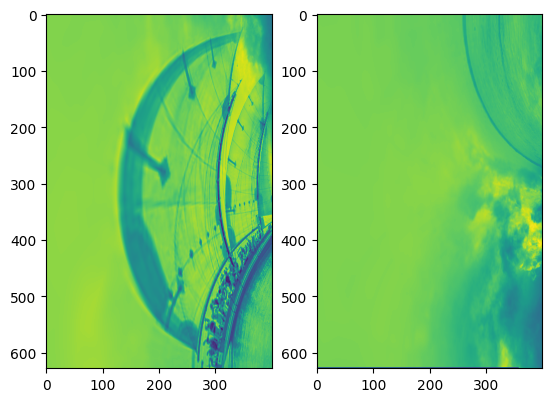

In [3]:
img = cv2.imread("/home/mateusz/Desktop/Magisterka/library_tests/sample_images/sailboat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255

center = (420, 250)
radius = 250
dsize = (1256, 400)

logimg = logpolar(img, center, dsize, radius)

folded_logimg = fold_logpolar(logimg)

# logimg = gray2rgb(logimg)

plt.subplot(1, 2, 1)
plt.imshow(np.real(folded_logimg))

plt.subplot(1, 2, 2)
plt.imshow(np.imag(folded_logimg))


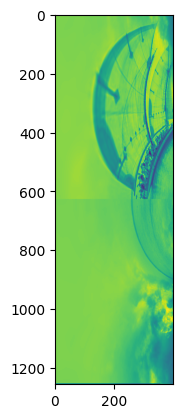

In [4]:
logimg_unfolded = unfold_logpolar(folded_logimg)

plt.imshow(logimg_unfolded)

### ECT source code

In [5]:
# class AntialiasParameters(BaseModel): 
#     factor: float
#     threshold: float
#     slope: float
#     vector: Any = Field(default=None)

# class Config(BaseModel):
#     logpolar_mode: Literal["offset", "omit", "opencv"] = Field(default="offset")
#     interpolation: Literal["bilinear", "none"] = Field(default="bilinear")
#     start_angle_deg: float = Field(default=90)
#     offset_value_px: int = Field(default=10)
#     ect_offset_value_px: int = Field(default=0)

#     antialias: bool = True
#     antialias_params: list[AntialiasParameters] = Field(default = None)
#     transform: Literal["ect", "iect"] = Field(default="ect")

#     @property
#     def start_angle_rad(self) -> float:
#         return math.pi * self.start_angle_deg / 180    
    
#     def validate(self):

#         if self.antialias is not None and self.antialias_params is None:
#             raise AttributeError("antialias needs antialias parameters specified")
        
#         if self.logpolar_mode == "offset" and self.offset_value_px is None:
#             raise AttributeError("logpolar offset mode requires an offset value")
        
#         if self.logpolar_mode == "offset" and self.ect_offset_value_px is None:
#             raise AttributeError("logpolar offset mode requires a transform offset value")


In [6]:
## new utils

import numpy as np

from ect.filters import sigmoid

def xcorr(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    '''
    Calculates 2D cross-correlation between two ndarrays
    using following equation:

    xcorr(a, b) = F(A)' * F(B)

    where F stands for Fourier transform
    
    Parameters
    ----------
    A, B : np.ndarray
        Input arrays

    Returns
    -------
    np.ndarray
        Cross-correlation between two arrays
    '''
    A_t = np.fft.fft2(A, axes=(0, 1))
    B_t = np.fft.fft2(B, axes=(0, 1))
    out_t = np.conjugate(A_t) * B_t
    return np.fft.ifft2(out_t, axes=(0,1))


def vectors(shape: tuple[int, int], cfg: Config
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    '''
    Generates base vectors
    for a given shape, in range 
    [1, log(R)] x (0, pi)

    These vectors apply to image folded onto one
    half of plane (x > 0)

    Parameters
    ----------
    shape : tuple[int, int]
        shape of kernel image
    flags : int, optional
        launch configuration, by default ECT_START_PX

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        Tuple of gamma, phi, x and y vectors
    '''

    P, R = shape

    gamma = np.linspace(-1+1/R, 1, 2*R) * np.log(R)
    phi = np.linspace(1/P, 2, 2*P) * np.pi
    phi -= cfg.start_angle_rad

    gammas, phis = np.meshgrid(gamma, phi)
    xs = np.exp(gammas) * np.cos(phis)    
    ys = np.exp(gammas) * np.sin(phis)

    return gammas, phis, xs, ys

def antialias(
    kernel: np.ndarray, 
    params: list[AntialiasParameters],
    ) -> np.ndarray:
    '''
    Applies antialiasing filter to a kernel

    Parameters
    ----------
    kernel : np.ndarray
        _description_
    cfg: Config
        ECT library launch configuration
        
    Returns
    -------
    np.ndarray
        Kernel with applied antialiasing
    '''
    for p in params:  
        filt = sigmoid(1/p.slope*(p.threshold-p.factor*abs(p.vector)))
        kernel *= filt

    return kernel


def mod_image(
    image: np.ndarray, 
    cfg: Config):
    '''
    Prepares imadd

    Parameters
    ----------
    image : np.ndarray
        _description_
    ect_offset : int
        _description_
    flags : int, optional
        _description_, by default ECT_OMIT_ORIGIN | ECT_START_PX

    Returns
    -------
    _type_
        _description_
    '''
    P, R = image.shape[:2]
    image_padded = np.zeros((2*P, 2*R), dtype=complex)

    rhos, _, xs, _ = vectors((P, R), cfg)
    xs += cfg.offset
    rhos = rhos[:P, :R]
    xs = xs[:P, :R]

    ect_factor = 1 if cfg.transform == "ect" else -1

    if cfg.mode == "offset":
        image_padded[:P, :R] = np.conjugate(image) * \
            np.exp(2*rhos - ect_factor*2*np.pi*1j*cfg.ect_offset_value_px*xs/R)
    elif cfg.mode == "omit":
        image_padded[:P, :R] = np.conjugate(image) * np.exp(2*rhos)
    else:
        raise AttributeError('logpolar mode not in ["offset", "omit"]')

    return image_padded


def shift(
    image: np.ndarray, 
    cfg: Config):

    P, R = image.shape[:2]
    _, _, xs, _ = vectors((P, R), cfg)
    xs += cfg.offset
    xs = xs[:P, :R]

    ect_factor = 1 if cfg.transform == "ect" else -1

    return np.exp(ect_factor*2*np.pi*1j*cfg.offset_value_px*xs/R)


In [7]:
DEFAULT_CONFIG = Config(
    logpolar_mode = "omit",
    interpolation = "none",
    antialias = False
)

def transform(inp: np.ndarray, cfg: Config) -> np.ndarray:
    P, R = inp.shape[:2]
    _, _, xs, ys = vectors((P, R), cfg)

    ect_factor = -1 if cfg.transform == "ect" else 1
    kernel = np.exp(2 * np.pi * 1j * xs * ect_factor)
    
    if cfg.antialias:
        cfg.antialias_params[0].vector = xs
        cfg.antialias_params[1].vector = ys
        kernel = antialias(kernel, cfg.antialias_params)

    if cfg.mode == "offset":
        shift_ = shift(inp, cfg)

    image_padded = mod_image(inp, cfg)
    out = xcorr(image_padded, kernel)
    out = out[:P, :R]
    return shift_ * out if cfg.mode == "offset" else out


def fect(
    image: cv2.Mat | np.ndarray,
    cfg: Config = DEFAULT_CONFIG
    ) -> cv2.Mat:
    '''
    Implementation of Fast ECT O(n^2*logn)
    '''
    cfg.validate()
    image = fold_logpolar(image)
    return transform(image, cfg)

def ifect(
    ect: cv2.Mat,
    cfg: Config = DEFAULT_CONFIG
) -> cv2.Mat:
    '''
    Implementation of Inverse FECT O(n^2)
    '''
    cfg.validate()
    cfg.transform = "ifect"
    out = transform(ect, cfg)
    return unfold_logpolar(out)

### Folded ECT testing

#### Sample Image

In [8]:
def circular_grid(
    dsize: tuple[int, int], 
    radius_step: int, 
    angle_step_deg: int,
    thickness: int = 1
) -> np.ndarray:
    '''
    Generates circular grid of size [dsize]
    centered at middle of the image and
    parametrized radius and angle step.

    Outputs grid as grayscale image.
    '''
    out: np.ndarray = np.ones(dsize, dtype=float)
    xc, yc = dsize[0]//2, dsize[1]//2

    max_radius = max(xc, yc)

    for r in range(0, max_radius+1, radius_step):
        # ic(xc, yc, r)
        out = cv2.circle(out, (xc, yc), r, (0), thickness)
    
    for ang in range(0, 360, angle_step_deg):
        phi: float = np.pi * ang / 180
        px: int = int(xc + max_radius*np.cos(phi))
        py: int = int(yc + max_radius*np.sin(phi))
        # ic((xc, yc), (px, py), ang)
        out = cv2.line(out, (xc, yc), (px, py), (0), thickness)
    
    return out

def square_grid(
    dsize: tuple[int, int], 
    step: int, 
    thickness: int = 1
) -> np.ndarray:
    '''
    Generates square grid of size [dsize]
    with parametrized step.

    Outputs grid as grayscale image.
    '''
    out: np.ndarray = np.ones(dsize, dtype=float)

    # x grid
    for x in range(0, dsize[1]+1, step):
        # ic(x)
        out = cv2.line(out, (x, 0), (x, dsize[0]), (0), thickness)
    
    # y grid
    for y in range(0, dsize[0]+1, step):
        # ic(y)
        out = cv2.line(out, (0, y), (dsize[1], y), (0), thickness)
    
    return out

#### ECT code

In [9]:
SIZE = 500
ANGLE = 90
# DSIZE = (628, 200)
DSIZE = (314, 100)

from ect import (
    sidelobe, 
    ifect as libifect, 
    fect as libfect
)

img = square_grid((SIZE, SIZE), SIZE//10, thickness=SIZE//20)
# img = np.ones((SIZE, SIZE))
logimg = logpolar(img, (SIZE//2, SIZE//2), DSIZE, SIZE//2)
logimg *= sidelobe(logimg.shape, offset=0)[:, :, 0]

ect_cfg = Config(
    mode = "offset",
    offset_value_px = 5,
    ect_offset_value_px = 5,
    antialias = True,
)

aa_params = [
    AntialiasParameters(
        factor = 0.15, # to optimize
        threshold = 1,
        slope = 0.25
    ),   
    AntialiasParameters(
        factor = 0.10, # to optimize
        threshold = 1,
        slope = 0.25
    )
]

from ect import norm_minmax
from icecream import ic

ect_cfg.antialias_params = aa_params

ect = libfect(logimg, ect_cfg)
# ect[:, 200:] = 0
inv = libifect(ect, ect_cfg)

plt.subplot(1, 3, 1)
# logimg = gray2rgb(logimg)
plt.imshow(logimg)

plt.subplot(1, 3, 2)
ect = unfold_logpolar(ect)
ect = complex_to_hsv(ect)
plt.imshow(ect)

plt.subplot(1, 3, 3)
# inv = norm_minmax(inv, 0, 255)
# inv = gray2rgb(inv/255)
plt.imshow(inv)

2024-06-11 09:19:04.604 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=10
2024-06-11 09:19:04.605 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping


TypeError: sidelobe() got an unexpected keyword argument 'offset'

-4.619405447087796

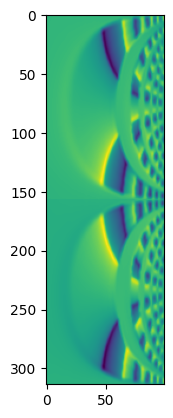

In [ ]:
from ect.optimization import snr, rmsn
plt.imshow(rmsn(logimg) - rmsn(inv))

snr(inv, logimg)

In [ ]:
snr()

TypeError: snr() missing 2 required positional arguments: 'img' and 'template'